In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from src.eda import BCW_Explorer
from sklearn import preprocessing

sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})

In [2]:
eda = BCW_Explorer()

In [3]:
eda.data.describe()

summaries         mean                                                     \
attributes      radius     texture circumference         area  smoothness   
count       569.000000  569.000000    569.000000   569.000000  569.000000   
mean         14.127292   19.289649     91.969033   654.889104    0.096360   
std           3.524049    4.301036     24.298981   351.914129    0.014064   
min           6.981000    9.710000     43.790000   143.500000    0.052630   
25%          11.700000   16.170000     75.170000   420.300000    0.086370   
50%          13.370000   18.840000     86.240000   551.100000    0.095870   
75%          15.780000   21.800000    104.100000   782.700000    0.105300   
max          28.110000   39.280000    188.500000  2501.000000    0.163400   

summaries                                                               \
attributes     density concavity_intensity concavity_count    symmetry   
count       569.000000          569.000000      569.000000  569.000000   
mean          0.104341            0.088799        0.048919    0.181162   
std           0.052813            0.079720        0.038803    0.027414   
min           0.019380            0.000000        0.000000    0.106000   
25%           0.064920            0.029560        0.020310    0.161900   
50%           0.092630            0.061540        0.033500    0.179200   
75%           0.130400            0.130700        0.074000    0.195700   
max           0.345400            0.426800        0.201200    0.304000   

summaries                     ...   mean_max3                             \
attributes fractal_dimension  ...     texture circumference         area   
count             569.000000  ...  569.000000    569.000000   569.000000   
mean                0.062798  ...   25.677223    107.261213   880.583128   
std                 0.007060  ...    6.146258     33.602542   569.356993   
min                 0.049960  ...   12.020000     50.410000   185.200000   
25%                 0.057700  ...   21.080000     84.110000   515.300000   
50%                 0.061540  ...   25.410000     97.660000   686.500000   
75%                 0.066120  ...   29.720000    125.400000  1084.000000   
max                 0.097440  ...   49.540000    251.200000  4254.000000   

summaries                                                               \
attributes  smoothness     density concavity_intensity concavity_count   
count       569.000000  569.000000          569.000000      569.000000   
mean          0.132369    0.254265            0.272188        0.114606   
std           0.022832    0.157336            0.208624        0.065732   
min           0.071170    0.027290            0.000000        0.000000   
25%           0.116600    0.147200            0.114500        0.064930   
50%           0.131300    0.211900            0.226700        0.099930   
75%           0.146000    0.339100            0.382900        0.161400   
max           0.222600    1.058000            1.252000        0.291000   

summaries                                      label  
attributes    symmetry fractal_dimension              
count       569.000000        569.000000  569.000000  
mean          0.290076          0.083946    0.372583  
std           0.061867          0.018061    0.483918  
min           0.156500          0.055040    0.000000  
25%           0.250400          0.071460    0.000000  
50%           0.282200          0.080040    0.000000  
75%           0.317900          0.092080    1.000000  
max           0.663800          0.207500    1.000000  

[8 rows x 31 columns]

## > How are the classes distributed?

In [4]:
def plot_compare_classdistribution(df: pd.DataFrame, summary='mean', ax=None):
    # scales the data
    df = df.apply(preprocessing.scale, axis=0)

    # melts columns' (name, value) pair into two columns
    df =\
        pd.melt(
            pd.concat(
                [
                    df['label'],
                    df.xs(summary, level='summaries', axis=1)
                ],
                axis=1
            ),
            id_vars='label',
            var_name='features',
            value_name='value'
        )

    # plots comparative distribution of classes for each 'mean' feature
    return\
        sns.violinplot(
            ax=ax,
            data=df,
            y="value",
            x="features",
            hue="label",
            inner="quart",
            split=True,
        )


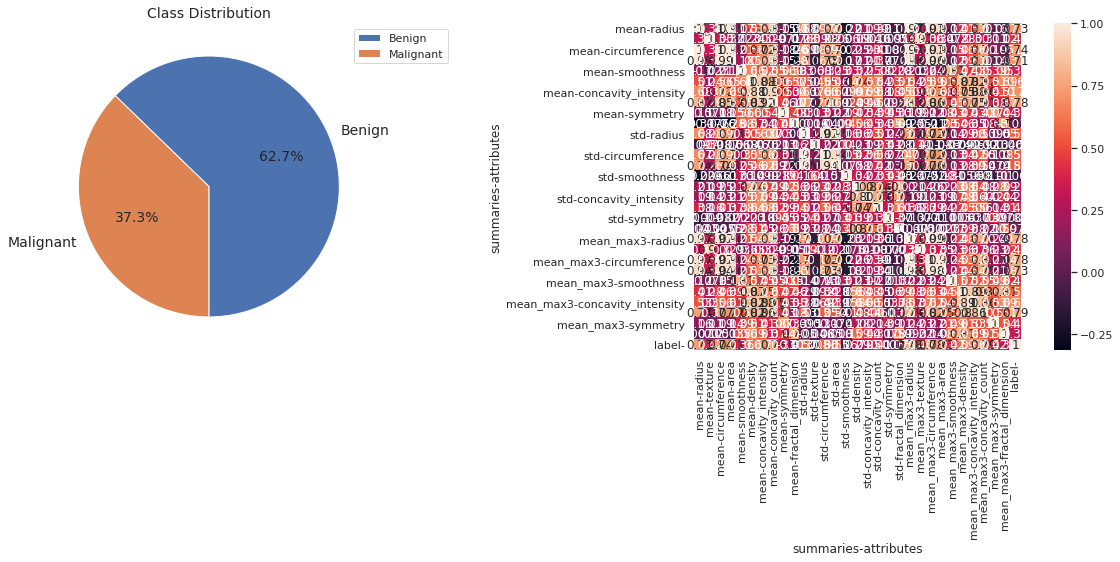

In [5]:
fig = plt.figure()
gs = fig.add_gridspec(2,2, figsize=(20, 6), width_ratios=[1,2])
ax0 = fig.add_subplots(gs[0, 0])
# ax = fig.add_subplots(gs[0, 0] , gridspec_kw = {'width_ratios':[1, 2]})
ax0.set_title('Class Distribution', fontsize=14)

eda.data['label']\
    .map({1: 'Malignant', 0: 'Benign'})\
    .value_counts()\
    .plot(
        ax=ax0,
        kind='pie',
        autopct='%1.1f%%',
        startangle=270,
        fontsize=14,
        label=''
    )

ax1 = fig.add_subplot(gs[0, 1])
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1 .spines['left'].set_visible(False)

plot_compare_classdistribution(eda.data, ax=ax[1], summary='mean_max3')

ax1.tick_params(axis='x', labelrotation=30)
ax1.legend_.remove()
ax0.legend(['Benign', 'Malignant'], loc='upper right', bbox_to_anchor=(1.25, 1))

# ax2 = plt.subplots(222)
sns.heatmap(eda.data.corr(), vmax=1, square=True, annot=True)


plt.show()

LAY SOME INTERPRETATION HERE

In [6]:
eda.data.drop('label', axis=1)

summaries    mean                                                    \
attributes radius texture circumference    area smoothness  density   
0           17.99   10.38        122.80  1001.0    0.11840  0.27760   
1           20.57   17.77        132.90  1326.0    0.08474  0.07864   
2           19.69   21.25        130.00  1203.0    0.10960  0.15990   
3           11.42   20.38         77.58   386.1    0.14250  0.28390   
4           20.29   14.34        135.10  1297.0    0.10030  0.13280   
..            ...     ...           ...     ...        ...      ...   
564         21.56   22.39        142.00  1479.0    0.11100  0.11590   
565         20.13   28.25        131.20  1261.0    0.09780  0.10340   
566         16.60   28.08        108.30   858.1    0.08455  0.10230   
567         20.60   29.33        140.10  1265.0    0.11780  0.27700   
568          7.76   24.54         47.92   181.0    0.05263  0.04362   

summaries                                                                  \
attributes concavity_intensity concavity_count symmetry fractal_dimension   
0                      0.30010         0.14710   0.2419           0.07871   
1                      0.08690         0.07017   0.1812           0.05667   
2                      0.19740         0.12790   0.2069           0.05999   
3                      0.24140         0.10520   0.2597           0.09744   
4                      0.19800         0.10430   0.1809           0.05883   
..                         ...             ...      ...               ...   
564                    0.24390         0.13890   0.1726           0.05623   
565                    0.14400         0.09791   0.1752           0.05533   
566                    0.09251         0.05302   0.1590           0.05648   
567                    0.35140         0.15200   0.2397           0.07016   
568                    0.00000         0.00000   0.1587           0.05884   

summaries   ... mean_max3                                                    \
attributes  ...    radius texture circumference    area smoothness  density   
0           ...    25.380   17.33        184.60  2019.0    0.16220  0.66560   
1           ...    24.990   23.41        158.80  1956.0    0.12380  0.18660   
2           ...    23.570   25.53        152.50  1709.0    0.14440  0.42450   
3           ...    14.910   26.50         98.87   567.7    0.20980  0.86630   
4           ...    22.540   16.67        152.20  1575.0    0.13740  0.20500   
..          ...       ...     ...           ...     ...        ...      ...   
564         ...    25.450   26.40        166.10  2027.0    0.14100  0.21130   
565         ...    23.690   38.25        155.00  1731.0    0.11660  0.19220   
566         ...    18.980   34.12        126.70  1124.0    0.11390  0.30940   
567         ...    25.740   39.42        184.60  1821.0    0.16500  0.86810   
568         ...     9.456   30.37         59.16   268.6    0.08996  0.06444   

summaries                                                                  
attributes concavity_intensity concavity_count symmetry fractal_dimension  
0                       0.7119          0.2654   0.4601           0.11890  
1                       0.2416          0.1860   0.2750           0.08902  
2                       0.4504          0.2430   0.3613           0.08758  
3                       0.6869          0.2575   0.6638           0.17300  
4                       0.4000          0.1625   0.2364           0.07678  
..                         ...             ...      ...               ...  
564                     0.4107          0.2216   0.2060           0.07115  
565                     0.3215          0.1628   0.2572           0.06637  
566                     0.3403          0.1418   0.2218           0.07820  
567                     0.9387          0.2650   0.4087           0.12400  
568                     0.0000          0.0000   0.2871           0.07039  

[569 rows x 30 columns]